In [5]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [5]:
import numpy as np
import gym
from gym import spaces

def winprob(a):
    return 1/(1+np.exp(-3+3*a))

def stateTransition(s, win, lead, distance): 
    if win:
        return lead + 2 * distance
    return max(s - 1, 0)

class ShippingEnv(gym.Env):
    def __init__(self):
        super(ShippingEnv, self).__init__()

        self.lead = 15
        self.distance = 20
        self.w = 100
        self.T = 1000
        self.Arrivalprob = 0.3
        self.actions = np.linspace(0.5, 2, 20)

        self.observation_space = spaces.Discrete(self.lead + 2 * self.distance + 1)
        self.action_space = spaces.Discrete(len(self.actions))

        self.state = self.observation_space.sample()
        self.time = 0

    def step(self, action):
        assert self.action_space.contains(action)

        self.time += 1

        offer_received = np.random.rand() < self.Arrivalprob
        win = np.random.rand() < winprob(self.actions[action])

        # If an offer is received, and the agent accepts it (action > 0), calculate reward and update state
        if offer_received and action > 0:
            self.state = stateTransition(self.state, win, self.lead, self.distance)
            reward = win * self.actions[action] * self.w
        else:
            self.state = max(self.state - 1, 0)
            reward = 0

        done = self.time == self.T

        return np.array(self.state).reshape((1, 1)), reward, done, {}

    def reset(self):
        self.state = self.observation_space.sample()
        self.time = 0
        return np.array(self.state).reshape((1, 1))

In [5]:
import numpy as np
import gym
from gym import spaces

class ShippingEnv(gym.Env):
    def __init__(self):
        super(ShippingEnv, self).__init__()

        self.lead = 15
        self.distance = 20
        self.w = 100
        self.T = 1000
        self.Arrivalprob = 0.3
        self.actions = np.linspace(0.5, 2, 20)

        self.observation_space = spaces.Discrete(self.lead + 2 * self.distance + 1)
        self.action_space = spaces.Discrete(len(self.actions))

        self.state = self.observation_space.sample()
        self.time = 0

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [41:27<00:00, 20.10it/s]  


********Average reward per thousand episodes********

1000 :  11185.997368421056
2000 :  12440.681578947368
3000 :  13174.068421052636
4000 :  13545.078947368385
5000 :  13832.513157894715
6000 :  13968.213157894716
7000 :  13974.907894736816
8000 :  14308.526315789459
9000 :  14103.744736842098
10000 :  14203.989473684216
11000 :  13955.757894736835
12000 :  14158.015789473684
13000 :  14245.160526315805
14000 :  14302.099999999993
15000 :  14102.41315789472
16000 :  14164.468421052614
17000 :  14175.66842105263
18000 :  14229.57368421052
19000 :  14162.644736842096
20000 :  14049.334210526307
21000 :  14243.68947368421
22000 :  14208.831578947353
23000 :  14140.744736842094
24000 :  14353.184210526319
25000 :  14257.352631578913
26000 :  14181.039473684203
27000 :  13982.828947368404
28000 :  14333.26315789473
29000 :  14210.718421052616
30000 :  14108.84210526315
31000 :  14132.357894736828
32000 :  14215.957894736832
33000 :  14247.889473684198
34000 :  14058.965789473663
35000 :  

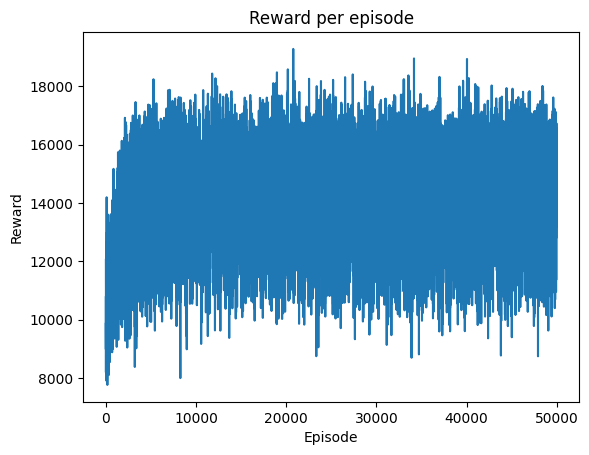

In [7]:
import numpy as np
import gym
from gym import spaces
from tqdm import tqdm
import matplotlib.pyplot as plt

def winprob(a):
    return 1/(1+np.exp(-3+3*a))

def stateTransition(s, win, lead, distance): 
    if win:
        return lead + 2 * distance
    return max(s - 1, 0)

class ShippingEnv(gym.Env):
    def __init__(self):
        super(ShippingEnv, self).__init__()

        self.lead = 15
        self.distance = 20
        self.w = 100
        self.T = 1000
        self.Arrivalprob = 0.3
        self.actions = np.linspace(0.5, 2, 20)

        self.observation_space = spaces.Discrete(self.lead + 2 * self.distance + 1)
        self.action_space = spaces.Discrete(len(self.actions))

        self.state = np.random.randint(0, self.observation_space.n)
        self.time = 0

    def step(self, action):
        assert self.action_space.contains(action)

        self.time += 1

        offer_received = np.random.rand() < self.Arrivalprob
        win = np.random.rand() < winprob(self.actions[action])

        # If an offer is received, and the agent accepts it (action > 0), calculate reward and update state
        if offer_received and action > 0:
            self.state = stateTransition(self.state, win, self.lead, self.distance)
            reward = win * self.actions[action] * self.w
        else:
            self.state = max(self.state - 1, 0)
            reward = 0

        done = self.time == self.T

        return np.array(self.state).reshape((1, 1)), reward, done, {}

    def reset(self):
        self.state = np.random.randint(0, self.observation_space.n)
        self.time = 0
        return np.array(self.state).reshape((1, 1))


# Define Q-Learning parameters
num_episodes = 50000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

# Initialize the environment
env = ShippingEnv()

# Initialize the Q-table
q_table = np.zeros((env.observation_space.n, env.action_space.n))

# List to hold all rewards
rewards_all_episodes = []

# Q-Learning algorithm
for episode in tqdm(range(num_episodes)):
    state = env.reset()
    state = state[0, 0]  # Getting the actual value from the array

    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode): 

        # Exploration-exploitation trade-off
        exploration_rate_threshold = np.random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:]) 
        else:
            action = np.random.choice(env.action_space.n) 

        new_state, reward, done, info = env.step(action)
        new_state = new_state[0, 0]  # Getting the actual value from the array

        # Update Q-table for Q(s,a)
        q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))

        state = new_state
        rewards_current_episode += reward 

        if done == True: 
            break

    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
 
    rewards_all_episodes.append(rewards_current_episode)

# Calculate and print the average reward per thousand episodes
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes),num_episodes/1000)
count = 1000
print("********Average reward per thousand episodes********\n")
for r in rewards_per_thousand_episodes:
    print(count, ": ", str(sum(r/1000)))
    count += 1000

# Visualize the reward
plt.plot(rewards_all_episodes)
plt.title('Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
